In [1]:
%%script bash 
python -m pip install trimesh rtree scipy open3d pptk

Defaulting to user installation because normal site-packages is not writeable


DEPRECATION: Python 2.7 reached the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 is no longer maintained. pip 21.0 will drop support for Python 2.7 in January 2021. More details about Python 2 support in pip can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support pip 21.0 will remove support for this functionality.
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [2]:
%%script bash 
rosparam set use_sim_time true

In [3]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import matplotlib.pyplot as plt
import rospy
import tf
from utils import *
os.environ["DARKNET_PATH"] = "/workspace/src/dependencies/darknet/"


In [4]:
import trimesh
import mesh_to_grasps
import grasp_metrics
import numpy as np
import rtree 
import rospy

from sensor_msgs.msg import PointCloud2, Image, CameraInfo, PointCloud, PointField
from geometry_msgs.msg import Point32
from std_msgs.msg import String
import sensor_msgs.point_cloud2 as pc2
import std_msgs.msg
import message_filters

import numpy as np
import time
import cv2
from cv_bridge import CvBridge
import darknet
import os
import random

import open3d as o3d
from open3d import JVisualizer
import pptk



Create objects and move the robot toward them

In [5]:
rospy.init_node('demo')

put_object("cracker_box", 0.6, 1.9, 0.5)
put_object("mustard_bottle", 1.0, 1.8, 0.5)
put_object("mug", 0.8, 1.7, 0.5)
put_object("foam_brick", 1.2, 1.7, 0.5)

# Move toward the table
# look down a little
move_head_tilt(-0.5)

# move position
move_arm_init()
# move in front of the long table
move_base_goal(1, 1, 90)
# Look for objects
time.sleep(1)

Load Darknet config (YOLOV4)

In [6]:
darknet_config_dir = os.path.join(os.environ.get('DARKNET_PATH', './'), "darknet_config/")
config_file = darknet_config_dir+"yolov4-tiny-obj.cfg"
data_file = darknet_config_dir+"obj.data"
weights = darknet_config_dir+"yolov4-tiny-obj_last.weights"
random.seed(3)  # deterministic bbox colors
network, class_names, class_colors = darknet.load_network(config_file, data_file, weights, batch_size=1)

prev_time = time.time()

bridge = CvBridge()

Get the current RGB and Depth Image from ROS

In [7]:
image_rgb = rospy.wait_for_message('/hsrb/head_rgbd_sensor/rgb/image_rect_color', Image)
image_depth = rospy.wait_for_message('/hsrb/head_rgbd_sensor/depth_registered/image_rect_raw', Image)
pointcloud = rospy.wait_for_message('/hsrb/head_rgbd_sensor/depth_registered/rectified_points', PointCloud2)

Transform from OpenCV (cv2)

In [8]:
image_cv2 = bridge.imgmsg_to_cv2(image_rgb, "bgr8")
rospy.get_rostime()

rospy.Time[1316124000000]

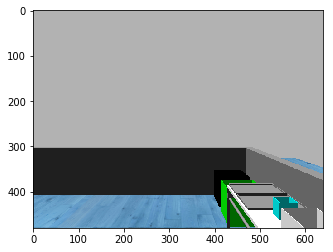

In [9]:
plt.imshow(image_cv2)
plt.show()

Perform detection using darknet

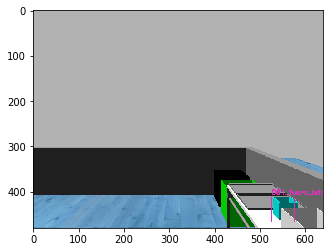

In [10]:
def image_detection(image, network, class_names, class_colors, thresh=0.25):
    # Darknet doesn't accept numpy images.
    # Create one with image we reuse for each detect
    # width = darknet.network_width(network)
    # height = darknet.network_height(network)
    width = 640
    height = 480
    height = darknet.network_height(network)
    darknet_image = darknet.make_image(width, height, 3)

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_resized = cv2.resize(image_rgb, (width, height), interpolation=cv2.INTER_LINEAR)

    darknet.copy_image_from_bytes(darknet_image, image_resized.tobytes())
    detections = darknet.detect_image(network, class_names, darknet_image, thresh=thresh)
    darknet.free_image(darknet_image)
    image = darknet.draw_boxes(detections, image_resized, class_colors)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB), detections

image, detections = image_detection(image_cv2, network, class_names, class_colors)
plt.imshow(image)
plt.show()

Get the box coordinates from the first object

In [11]:
def convertCoords(x1, y1, w_size, h_size):
    x_start = 	int(round(x1 - (w_size/2)))
    y_start = 	int(round(y1 - (h_size/2)))
    x_end   = 	int(round(x_start + w_size))
    y_end   = 	int(round(y_start + h_size))
    return x_start, y_start, x_end, y_end

x, y, w, h = detections[1][2][0], detections[1][2][1], detections[1][2][2], detections[1][2][3]
x_start, y_start, x_end, y_end = convertCoords(x,y,w,h)


IndexError: list index out of range

Get the object corresponding pointcloud by cropping the global pointcloud 

In [ ]:
def crop_pointcloud( min_x, min_y, max_x, max_y, width, height, pointcloud_sub):
    points = []
    for i in range(min_x, max_x):
        for j in range(min_y, max_y):
            points.append([i, j])

    points = list(pc2.read_points(pointcloud_sub, field_names=("x", "y", "z"), skip_nans=True, uvs=points))
    return points
    
points = crop_pointcloud(x_start, y_start, x_end, y_end, w, h, pointcloud)

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)

visualizer = JVisualizer()
visualizer.add_geometry(pcd)
visualizer.show()
